In [1]:
import torch
import numpy as np
import pandas as pd

from NeuralProcessClasses_Proteins import *
from architecture_classes import *
from utils import *

In [2]:
msa = pd.read_csv('SH3_Full_Dataset_8_9_22.csv')
msa['Type'].unique()
naturals_msa = msa[msa['Type']=='Naturals']
seqs = np.asarray([list(seq) for seq in naturals_msa['Sequences']])
norm_re = np.asarray([re for re in naturals_msa['Norm_RE']])

default_aa_keys='-GALMFWKQESPVICYHRNDT'
def fasta_to_df(fasta_file, aa_keys = default_aa_keys):
    """
    creates one hot encoding of a fasta file using biopython's alignio.read process. 
    fasta_file : filepath leading to msa file in fasta format at hand
    """
    column_names = []
    column_names.extend(aa_keys)
    msa=AlignIO.read(fasta_file, "fasta")
    num_columns = len(msa[0].seq)
    column_names = column_names*num_columns
    column_names.append('sequence')
    column_names.append('id')
    init = np.zeros((len(msa), len(column_names)))
    df = pd.DataFrame(init, columns = column_names)
    df.sequence = df.sequence.astype(str)
    df.id=df.id.astype(str)
    
    for row_num, alignment in tqdm(enumerate(msa)):
        sequence = str(alignment.seq)
        for index, char in enumerate(sequence):
            place = aa_keys.find(char)
            df.iloc[row_num, index*len(aa_keys) + place] = 1
        
        df.iloc[row_num,-2]=str(alignment.seq)
        df.iloc[row_num,-1]=str(alignment.id)
    
    return df

In [3]:
def create_frequency_matrix(df, aa_keys = default_aa_keys):
    """takes one hot encoded msa and returns the frequency of each amino acid at each site
    df : pandas dataframe whose columns are the one hot encoding of an msa
    """
    num_columns=len(df['sequence'][0])
    
    frequency_matrix = np.zeros( (len(aa_keys) , num_columns) )
    print('calcing sum')
    freq=df.sum()
    print('sum calced')
    
    num_entries=len(df)
    len_aa_keys = len(aa_keys)
    
    for i in tqdm(range(len(aa_keys))):
        for j in range(num_columns):
            frequency_matrix[i, j] = freq[ i + len_aa_keys * j] / num_entries
    
    return frequency_matrix

In [4]:
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm
vae_alignment = []
phenotypes = []

vae_data = msa[msa['Type']=='VAE'].reset_index()

for r in range(len(vae_data)):
    alignment = vae_data.loc[r]
    if len(alignment['Sequences'])==62:
        record = SeqRecord(seq = Seq(alignment['Sequences']), id = alignment['Header'])
    
    vae_alignment.append(record)
    phenotypes.append(alignment['Norm_RE'])

vae_alignment = AlignIO.MultipleSeqAlignment(vae_alignment)

AlignIO.write(vae_alignment, 'vae_alignment.fasta', 'fasta')

vae_df = fasta_to_df('vae_alignment.fasta')

freq_matrix = create_frequency_matrix(vae_df)

trim_positions = []

for i in range(freq_matrix.shape[1]):
    if 1 in freq_matrix[:,i]:
        trim_positions.append(i)

print(trim_positions)


vae_alignment_trimmed = []


for alignment in vae_alignment:
    new_seq = ''
    for i in range(62):
        if i not in trim_positions:
            new_seq+=alignment.seq[i]
    re_alignment = SeqRecord(seq=Seq(new_seq), id = alignment.id)
    vae_alignment_trimmed.append(re_alignment)

vae_alignment_trimmed = AlignIO.MultipleSeqAlignment(vae_alignment_trimmed)

AlignIO.write(vae_alignment_trimmed, 'vae_alignment_trimmed.fasta', 'fasta')

test_seqs = np.asarray([list(str(alignment.seq)) for alignment in vae_alignment_trimmed])

phenotypes = np.asarray(phenotypes)

11608it [01:01, 187.79it/s]


calcing sum
sum calced


100%|████████████████████████████████████████| 21/21 [00:00<00:00, 23252.48it/s]


[16, 17, 44]


In [5]:
class AddNorm(torch.nn.Module):
    def __init__(
        self,
        normalized_shape,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.layer_norm = torch.nn.LayerNorm(normalized_shape)
    def forward(
        self,
        x,
        sub_layer_x
    ):
        add = x + sub_layer_x
        return self.layer_norm(add)

In [6]:
class AttentiveNeuralProcess_Deterministic(torch.nn.Module):
    def __init__(
        self,
        x_dim, 
        y_dim,
        projected_dim,
        d_hidden, 
        d_model,
        heads,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.linear_1 = torch.nn.Linear(x_dim + y_dim, projected_dim)
        self.activation = torch.nn.SELU()

        self.self_mha_1 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.addnorm_1 = AddNorm(normalized_shape= projected_dim)
        self.dropout_1 = torch.nn.Dropout(0.1)

        self.self_mha_2 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.addnorm_2 = AddNorm(normalized_shape=projected_dim)
        self.dropout_2 = torch.nn.Dropout(0.1)

        self.context_projection = torch.nn.Linear(x_dim, projected_dim)
        self.target_projection = torch.nn.Linear(x_dim, projected_dim)
        
        self.cross_mha = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)

        self.linear_2 = torch.nn.Linear(projected_dim + x_dim, projected_dim)
        self.linear_3 = torch.nn.Linear(projected_dim + x_dim, projected_dim)
        self.linear_4 = torch.nn.Linear(projected_dim + x_dim, projected_dim)
        self.linear_5 = torch.nn.Linear(projected_dim + x_dim, y_dim)

    def cross_entropy(self, x, y):
        return torch.sum(-y * torch.log(x + 1e-6) - (1.-y)*torch.log(1. - x + 1e-6))

    def forward(self, context_x, context_y, target_x, target_y = None):
        context = torch.concat([context_x, context_y], dim=-1)
        x_1 = self.activation(self.linear_1(context))

        x_2, _ = self.self_mha_1(x_1, x_1, x_1)
        x_2    = self.addnorm_1(x_2, x_1)
        x_2    = self.dropout_1(x_2)

        x_3, _ = self.self_mha_2(x_2, x_2, x_2)
        x_3    = self.addnorm_2(x_3, x_2)
        x_3    = self.dropout_2(x_2)

        projected_context = self.context_projection(context_x)
        projected_target  = self.target_projection(target_x)
        
        cross_attended,_ = self.cross_mha(projected_target, projected_context, x_3)
        
        yhat = torch.concat([cross_attended, x_target], dim=-1)
        yhat = self.activation(self.linear_2(yhat))
        
        yhat = torch.concat([yhat, x_target], dim=-1)
        yhat = self.activation(self.linear_3(yhat))
        
        yhat = torch.concat([yhat, x_target], dim=-1)
        yhat = self.activation(self.linear_4(yhat))

        yhat = torch.concat([yhat, x_target], dim=-1)
        yhat = self.linear_5(yhat)
        
        yhat = torch.nn.Softmax(dim=-1)(yhat)

        if target_y is not None:
            cross_entropy = self.cross_entropy(yhat, target_y)
            return yhat, cross_entropy
        else:
            return yhat, 0
                                     

        


In [7]:
ANP_det = AttentiveNeuralProcess_Deterministic(
    1, 21, 128, 128, 128, 8
)

In [8]:
ANP_det

AttentiveNeuralProcess_Deterministic(
  (linear_1): Linear(in_features=22, out_features=128, bias=True)
  (activation): SELU()
  (self_mha_1): MultiHeadedAttention(
    (attention): DotProductAttention()
    (W_q): Linear(in_features=128, out_features=1024, bias=True)
    (W_k): Linear(in_features=128, out_features=1024, bias=True)
    (W_v): Linear(in_features=128, out_features=1024, bias=True)
    (W_o): Linear(in_features=1024, out_features=128, bias=True)
  )
  (addnorm_1): AddNorm(
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (dropout_1): Dropout(p=0.1, inplace=False)
  (self_mha_2): MultiHeadedAttention(
    (attention): DotProductAttention()
    (W_q): Linear(in_features=128, out_features=1024, bias=True)
    (W_k): Linear(in_features=128, out_features=1024, bias=True)
    (W_v): Linear(in_features=128, out_features=1024, bias=True)
    (W_o): Linear(in_features=1024, out_features=128, bias=True)
  )
  (addnorm_2): AddNorm(
    (layer_norm): Laye

In [9]:
proteins = ProteinDataset(data=seqs)
min_context = int(0.1 * seqs.shape[1])
max_context = int(0.9 * seqs.shape[1])
len_aa = seqs.shape[1]
loader = torch.utils.data.DataLoader(proteins, batch_size=32, shuffle=True)

for batch in loader:
    break
(((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa, 1, 21)


In [10]:
ANP_det(x_context, y_context, x_target, y_target)

(tensor([[[3.5835e-04, 2.6647e-04, 7.5835e-03,  ..., 2.0244e-03,
           7.0126e-03, 2.3090e-02],
          [1.7431e-04, 1.2880e-04, 5.1384e-03,  ..., 1.1936e-03,
           4.8473e-03, 1.8830e-02],
          [1.3055e-04, 9.6441e-05, 4.3880e-03,  ..., 9.6454e-04,
           4.1777e-03, 1.7291e-02],
          ...,
          [1.1295e-04, 8.3479e-05, 4.0532e-03,  ..., 8.6688e-04,
           3.8779e-03, 1.6559e-02],
          [3.4965e-03, 2.7442e-03, 2.5257e-02,  ..., 1.0212e-02,
           2.0575e-02, 4.0891e-02],
          [1.6201e-02, 1.4010e-02, 5.0745e-02,  ..., 2.6948e-02,
           3.5486e-02, 5.1035e-02]],
 
         [[3.4747e-03, 2.7337e-03, 2.5280e-02,  ..., 1.0340e-02,
           2.0554e-02, 4.2116e-02],
          [7.9860e-03, 6.5923e-03, 3.7769e-02,  ..., 1.7812e-02,
           2.8404e-02, 4.8797e-02],
          [1.4951e-03, 1.1429e-03, 1.6387e-02,  ..., 5.7728e-03,
           1.4131e-02, 3.4720e-02],
          ...,
          [9.7647e-04, 7.3865e-04, 1.3092e-02,  ..., 4.264

In [11]:
def adjust_learning_rate(optimizer, step_num, warmup_step=4000):
    lr = 0.001 * warmup_step**0.5 * min(step_num * warmup_step**-1.5, step_num**-0.5)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [12]:
from tqdm import tqdm
from tensorboardX import SummaryWriter

proteins = ProteinDataset(data=seqs)
syn_proteins = ProteinDataset(data=test_seqs)

EPOCHS=45
ANP_det.train()
optim = torch.optim.Adam(ANP_det.parameters(), lr = 1e-3)
writer = SummaryWriter()

global_step = 0

min_context = int(0.1 * seqs.shape[1])
max_context = int(0.9 * seqs.shape[1])
len_aa = seqs.shape[1]


for epoch in range(EPOCHS):
    loader = torch.utils.data.DataLoader(proteins, batch_size=32, shuffle=True)
    overall_loss = 0
    for i, batch in enumerate(loader):

        
        global_step+=1
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa, 1, 21)
        
        adjust_learning_rate(optim, global_step)
        
        y_pred, loss = ANP_det(x_context, y_context, x_target, y_target)

        optim.zero_grad()
        loss.backward()
        optim.step()

        writer.add_scalars('training_loss',{
                    'loss':loss,
                }, global_step)

    val_loader = torch.utils.data.DataLoader(syn_proteins, batch_size=32, shuffle=False)
    for batch in val_loader:
        
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa, 1, 21)
        val_y_pred, val_loss = ANP_det(x_context, y_context, x_target, y_target)
        overall_loss += val_loss.item()

    print('validation loss at epoch {} is '.format(epoch) + str(overall_loss/(test_seqs.shape[0]*test_seqs.shape[1])))

validation loss at epoch 0 is 3.8505323911975067
validation loss at epoch 1 is 3.701777262273781
validation loss at epoch 2 is 3.680813300582992
validation loss at epoch 3 is 3.643248987698614
validation loss at epoch 4 is 3.6416000966695234
validation loss at epoch 5 is 3.5897274396312833
validation loss at epoch 6 is 3.562509667636799
validation loss at epoch 7 is 3.5311540430011465
validation loss at epoch 8 is 3.5015016741666236
validation loss at epoch 9 is 3.453404699134245
validation loss at epoch 10 is 3.49460342817709
validation loss at epoch 11 is 3.42166330228153
validation loss at epoch 12 is 3.4117346278814233
validation loss at epoch 13 is 3.372812533908024
validation loss at epoch 14 is 3.315049077772471
validation loss at epoch 15 is 3.281330435308532
validation loss at epoch 16 is 3.2751466547706634
validation loss at epoch 17 is 3.2154891567272332
validation loss at epoch 18 is 3.2729680870396676
validation loss at epoch 19 is 3.1846249895452634
validation loss at epo

In [38]:
x_target.shape

torch.Size([24, 59, 1])

In [13]:
val_y_pred[0][0]

tensor([2.6121e-02, 7.3778e-03, 7.5174e-03, 9.4540e-03, 2.5536e-02, 5.0070e-02,
        1.2349e-01, 4.0074e-03, 3.9315e-03, 4.0233e-02, 2.4191e-01, 2.1097e-02,
        9.9020e-03, 8.3307e-03, 7.9315e-04, 1.4710e-02, 1.1715e-02, 2.8449e-04,
        3.7828e-02, 2.9031e-01, 6.5380e-02], grad_fn=<SelectBackward0>)

In [28]:
AMINO_ACIDS = "ARNDCQEGHILKMFPSTWYV-"
IDX_TO_AA = list(AMINO_ACIDS)
AA_TO_IDX = {aa: i for i, aa in enumerate(IDX_TO_AA)}

frequency_matrix = np.zeros((seqs.shape[1], len(AA_TO_IDX)))

for i in range(seqs.shape[0]):
    for j in range(seqs.shape[1]):
        frequency_matrix[j,AA_TO_IDX[seqs[i,j]]] += 1

In [29]:
frequency_matrix

array([[ 668.,  280.,  248., ...,   63.,  342.,  260.],
       [ 617.,  226.,  347., ...,  263.,  523.,  148.],
       [ 402.,  212.,  245., ...,  117.,  748.,  106.],
       ...,
       [ 586.,  319.,  239., ...,  329., 1128.,  295.],
       [ 394.,  255.,  299., ...,   56.,  310., 1194.],
       [ 465.,  380.,  233., ...,   76.,  371., 1591.]])

In [33]:
x_target[0,1]

tensor([27.])

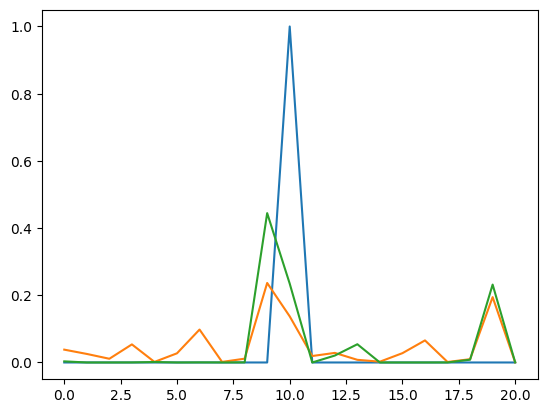

In [34]:
import matplotlib.pyplot as plt
plt.plot(y_target[0,1])
plt.plot(val_y_pred.detach().numpy()[0,1])
plt.plot(frequency_matrix[27]/7865)



In [93]:
x_target.shape

torch.Size([24, 59, 1])

In [39]:
class AttentiveNeuralProcess_Latent(torch.nn.Module):
    def __init__(
        self,
        x_dim, 
        y_dim,
        projected_dim,
        d_hidden, 
        d_model,
        heads,
        latent_dim,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.linear_1 = torch.nn.Linear(x_dim + y_dim, projected_dim)
        self.activation = torch.nn.SELU()

        self.deterministic_self_mha_1 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.addnorm_1 = AddNorm(normalized_shape= projected_dim)
        self.dropout_1 = torch.nn.Dropout(0.1)

        self.deterministic_self_mha_2 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.addnorm_2 = AddNorm(normalized_shape=projected_dim)
        self.dropout_2 = torch.nn.Dropout(0.1)

        self.latent_linear_1 = torch.nn.Linear(x_dim + y_dim, projected_dim)

        self.latent_self_mha_1 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.latent_addnorm_1 = AddNorm(normalized_shape= projected_dim)
        self.latent_dropout_1 = torch.nn.Dropout(0.1)

        self.latent_self_mha_2 = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)
        self.latent_addnorm_2 = AddNorm(normalized_shape=projected_dim)
        self.latent_dropout_2 = torch.nn.Dropout(0.1)

        self.latent_mu = torch.nn.Linear(projected_dim, latent_dim)
        self.latent_log_var = torch.nn.Linear(projected_dim, latent_dim)

    
        self.context_projection = torch.nn.Linear(x_dim, projected_dim)
        self.target_projection = torch.nn.Linear(x_dim, projected_dim)
        
        self.cross_mha = MultiHeadedAttention(heads, projected_dim, projected_dim, projected_dim, d_hidden, projected_dim)

        self.linear_2 = torch.nn.Linear(projected_dim + x_dim + latent_dim, projected_dim)
        self.linear_3 = torch.nn.Linear(projected_dim + x_dim + latent_dim, projected_dim)
        self.linear_4 = torch.nn.Linear(projected_dim + x_dim + latent_dim, projected_dim)
        self.linear_5 = torch.nn.Linear(projected_dim + x_dim + latent_dim, y_dim)

    def cross_entropy(self, x, y):
        return torch.sum(-y * torch.log(x + 1e-6) - (1.-y)*torch.log(1. - x + 1e-6))

    def reparam(self, z_mu, z_log_var):
        return z_mu + torch.randn_like(z_log_var) * torch.exp(z_log_var/2.)

    def kl_loss_calc(
        self, z_mu_context, z_log_var_context,
              z_mu_target,  z_log_var_target
    ):
        q_context = torch.distributions.Normal(z_mu_context, torch.exp(z_log_var_context/2))
        q_target = torch.distributions.Normal(z_mu_target, torch.exp(z_log_var_target/2))
        
        kl = torch.distributions.kl.kl_divergence(q_context, q_target)
        return kl

    def forward(self, context_x, context_y, target_x, target_y = None):
        context = torch.concat([context_x, context_y], dim=-1)
        x_1 = self.activation(self.linear_1(context))

        x_2, _ = self.deterministic_self_mha_1(x_1, x_1, x_1)
        x_2    = self.addnorm_1(x_2, x_1)
        x_2    = self.dropout_1(x_2)

        x_3, _ = self.deterministic_self_mha_2(x_2, x_2, x_2)
        x_3    = self.addnorm_2(x_3, x_2)
        x_3    = self.dropout_2(x_2)

        projected_context = self.context_projection(context_x)
        projected_target  = self.target_projection(target_x)
        
        cross_attended,_ = self.cross_mha(projected_target, projected_context, x_3)

        z_1 = self.latent_linear_1(context)

        z_2, _ = self.latent_self_mha_1(z_1, z_1, z_1)
        z_2    = self.latent_addnorm_1(z_2, z_1)
        z_2    = self.latent_dropout_1(z_2)

        z_3, _ = self.latent_self_mha_2(z_2, z_2, z_2)
        z_3    = self.latent_addnorm_2(z_3, z_2)
        z_3    = self.latent_dropout_2(z_3)

        z_3 = torch.mean(z_3, dim=1)

        z_mu = self.latent_mu(z_3)
        z_log_var = self.latent_log_var(z_3)

        z = self.reparam(z_mu, z_log_var)

        z = z.unsqueeze(dim=1).tile([1, target_x.shape[1],1])

        yhat = torch.concat([cross_attended, target_x, z], dim=-1)
        yhat = self.activation(self.linear_2(yhat))

        yhat = torch.concat([yhat, target_x, z], dim=-1)
        yhat = self.activation(self.linear_3(yhat))

        yhat = torch.concat([yhat, target_x, z], dim=-1)
        yhat = self.activation(self.linear_4(yhat))

        yhat = torch.concat([yhat, target_x, z], dim=-1)
        yhat = self.linear_5(yhat)
        yhat = torch.nn.Softmax(dim=-1)(yhat)

        if target_y is not None:
            cross_entropy = self.cross_entropy(yhat, target_y)
            target = torch.concat([target_x, target_y], dim=-1)
            target_1 = self.activation(self.latent_linear_1(target))

            target_2, _ = self.latent_self_mha_1(target_1, target_1, target_1)
            target_2    = self.latent_addnorm_1(target_2, target_1)
            target_2    = self.latent_dropout_1(target_2)

            target_3, _ = self.latent_self_mha_2(target_2, target_2, target_2)
            target_3    = self.latent_addnorm_2(target_3, target_2)
            target_3    = self.latent_dropout_2(target_3)

            z_target    = torch.mean(target_3, dim=1)
            target_z_mu = self.latent_mu(z_target)
            target_z_log_var = self.latent_log_var(z_target)

            kl_loss = torch.sum(self.kl_loss_calc(z_mu, z_log_var, target_z_mu, target_z_log_var))
            
            return yhat, cross_entropy + kl_loss
        else:
            return yhat, 0
                                     



In [40]:
ANP_lat = AttentiveNeuralProcess_Latent(
    1, 21, 128, 128, 128, 8, 4
)

In [43]:
ANP_lat

AttentiveNeuralProcess_Latent(
  (linear_1): Linear(in_features=22, out_features=128, bias=True)
  (activation): SELU()
  (deterministic_self_mha_1): MultiHeadedAttention(
    (attention): DotProductAttention()
    (W_q): Linear(in_features=128, out_features=1024, bias=True)
    (W_k): Linear(in_features=128, out_features=1024, bias=True)
    (W_v): Linear(in_features=128, out_features=1024, bias=True)
    (W_o): Linear(in_features=1024, out_features=128, bias=True)
  )
  (addnorm_1): AddNorm(
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (dropout_1): Dropout(p=0.1, inplace=False)
  (deterministic_self_mha_2): MultiHeadedAttention(
    (attention): DotProductAttention()
    (W_q): Linear(in_features=128, out_features=1024, bias=True)
    (W_k): Linear(in_features=128, out_features=1024, bias=True)
    (W_v): Linear(in_features=128, out_features=1024, bias=True)
    (W_o): Linear(in_features=1024, out_features=128, bias=True)
  )
  (addnorm_2): AddNorm(
 

In [ ]:
from tqdm import tqdm
from tensorboardX import SummaryWriter

proteins = ProteinDataset(data=seqs)
syn_proteins = ProteinDataset(data=test_seqs)

EPOCHS=45
ANP_lat.train()
optim = torch.optim.Adam(ANP_lat.parameters(), lr = 1e-3)
writer = SummaryWriter()

global_step = 0

min_context = int(0.1 * seqs.shape[1])
max_context = int(0.9 * seqs.shape[1])
len_aa = seqs.shape[1]


for epoch in range(EPOCHS):
    loader = torch.utils.data.DataLoader(proteins, batch_size=32, shuffle=True)
    overall_loss = 0
    for i, batch in tqdm(enumerate(loader)):
        ANP_lat.train()
        
        global_step+=1
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa, 1, 21)
        
        adjust_learning_rate(optim, global_step)
        
        y_pred, loss = ANP_lat(x_context, y_context, x_target, y_target)

        optim.zero_grad()
        loss.backward()
        optim.step()

        writer.add_scalars('training_loss',{
                    'loss':loss,
                }, global_step)

    val_loader = torch.utils.data.DataLoader(syn_proteins, batch_size=32, shuffle=False)
    for batch in val_loader:
        ANP_lat.eval()
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa, 1, 21)
        val_y_pred, val_loss = ANP_lat(x_context, y_context, x_target, y_target)
        overall_loss += val_loss.item()

    print('validation loss at epoch {} is '.format(epoch) + str(overall_loss/(test_seqs.shape[0]*test_seqs.shape[1])))

246it [00:40,  6.07it/s]


validation loss at epoch 0 is 3.55772761743595


246it [00:36,  6.75it/s]


validation loss at epoch 1 is 3.574536299785991


246it [00:40,  6.13it/s]


validation loss at epoch 2 is 3.547934505262708


246it [00:37,  6.59it/s]


validation loss at epoch 3 is 3.5495254068689115


246it [00:37,  6.48it/s]


validation loss at epoch 4 is 3.4900492105242384


246it [00:37,  6.48it/s]


validation loss at epoch 5 is 3.5465076034223824


246it [00:39,  6.26it/s]


validation loss at epoch 6 is 3.4800154483417614


246it [00:39,  6.18it/s]


validation loss at epoch 7 is 3.456097568745054


246it [00:41,  5.91it/s]


validation loss at epoch 8 is 3.596438067162322


246it [00:41,  5.96it/s]


validation loss at epoch 9 is 3.5130046925625336


246it [00:37,  6.58it/s]


validation loss at epoch 10 is 3.4532489738958523


246it [00:36,  6.77it/s]


validation loss at epoch 11 is 3.4210504860420086


246it [00:37,  6.56it/s]


validation loss at epoch 12 is 3.4123335222961826


246it [00:37,  6.54it/s]


validation loss at epoch 13 is 3.357143908340491


246it [00:39,  6.26it/s]


validation loss at epoch 14 is 3.303627122083351


246it [00:40,  6.02it/s]


validation loss at epoch 15 is 3.2731839911782785


246it [00:39,  6.29it/s]


validation loss at epoch 16 is 3.2310854019243287


246it [00:40,  6.04it/s]


validation loss at epoch 17 is 3.1987189481494807


246it [00:39,  6.24it/s]


validation loss at epoch 18 is 3.197216587409536


246it [00:41,  5.94it/s]


validation loss at epoch 19 is 3.118534228185385


246it [00:42,  5.78it/s]


validation loss at epoch 20 is 3.0963212734117653


246it [00:42,  5.84it/s]


validation loss at epoch 21 is 3.1087317962961967


246it [00:42,  5.73it/s]


validation loss at epoch 22 is 3.052243277587363


246it [00:39,  6.25it/s]


validation loss at epoch 23 is 3.0445006034487556


246it [00:40,  6.15it/s]


validation loss at epoch 24 is 3.021052861172188


246it [00:37,  6.64it/s]


validation loss at epoch 25 is 3.0186182664710066


246it [00:39,  6.24it/s]


validation loss at epoch 26 is 2.9671289732960595


246it [00:45,  5.40it/s]


validation loss at epoch 27 is 2.978053847761653


246it [00:42,  5.83it/s]


validation loss at epoch 28 is 2.9644481864488683


246it [00:39,  6.22it/s]


validation loss at epoch 29 is 2.9266055033738283


246it [00:38,  6.34it/s]


validation loss at epoch 30 is 2.9216270703885865


246it [00:40,  6.08it/s]


validation loss at epoch 31 is 2.9050904282798466


246it [00:39,  6.18it/s]


validation loss at epoch 32 is 2.893415754789878


246it [00:37,  6.56it/s]


validation loss at epoch 33 is 2.899412250887529


246it [00:41,  5.89it/s]


validation loss at epoch 34 is 2.8938244266868938


237it [00:39,  5.72it/s]

In [87]:
test

tensor([[[-1.0725, -0.5524, -0.5552]],

        [[-0.8216,  0.6530, -0.0530]],

        [[ 1.7631, -1.6940,  0.9103]],

        [[ 2.1919, -0.0126,  0.0225]],

        [[-0.6425, -1.7878,  2.2622]],

        [[ 1.0786,  0.0765, -1.6339]],

        [[-0.0836,  0.1963,  0.6273]],

        [[ 0.7639,  0.3908,  1.4168]],

        [[ 0.0147,  0.4423,  0.0785]],

        [[ 1.1422,  1.0022, -0.1402]]])

In [89]:
other_test = torch.randn((10,5,3))

In [90]:
other_test

tensor([[[ 5.7885e-01,  1.8503e+00,  4.2787e-01],
         [ 1.0071e+00,  1.4661e+00, -1.0260e-01],
         [-1.3728e+00,  1.9242e+00, -6.2077e-01],
         [-6.5727e-01, -7.5758e-01,  5.4797e-01],
         [-1.0862e+00,  1.4214e+00, -1.4982e-01]],

        [[-7.6549e-01,  1.5078e-01,  2.9107e-04],
         [-2.7137e-01, -1.8251e+00,  1.6859e+00],
         [-2.1129e+00,  2.3690e+00,  8.0102e-01],
         [ 2.6335e-02,  1.9552e-01, -4.6229e-01],
         [-2.7230e+00, -1.3442e+00, -8.8763e-01]],

        [[ 5.1638e-01,  7.2710e-01, -1.8898e+00],
         [-3.2572e-01,  1.0587e+00, -9.0792e-01],
         [-1.1495e+00,  4.6414e-01, -4.8468e-01],
         [ 1.0646e+00,  4.4712e-01, -6.7189e-01],
         [-9.7373e-01, -3.1889e-01, -1.9782e+00]],

        [[ 1.4106e+00,  8.3720e-01,  2.1635e-01],
         [-1.3530e+00,  2.7244e-01,  8.5228e-01],
         [-2.9217e+00,  4.1772e-03,  9.2262e-01],
         [ 1.2403e+00,  5.4462e-01, -1.6630e-01],
         [-5.1164e-01,  1.2458e+00,  9.4213e

In [91]:
torch.concat([test, other_test], dim=-1)

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 1 but got size 5 for tensor number 1 in the list.